# EVCSAP Stochastic Programming - SP converge Test - Parallel
*Author: Gen LI; Date: 13.01.23*


In [1]:
# Import local scripts

# import src.c.d

import os, sys
currentdir = os.path.dirname(os.path.realpath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)


In [2]:

from csap_packages_sp import sp_data_process as Dap
# from csap_packages_sp import sp_model_setup as Sup
from csap_packages_sp import sp_model_setup_by_fm_data as SupSP
from csap_packages_sp import sp_stat_compu as Stac
from csap_packages_sp import sp_sce_generation as Sceg
from csap_packages_sp.sp_mpd_frame_model_setup import _build_mpdp_csap_frame


ModuleNotFoundError: No module named 'idaes'

In [1]:


# Import Opensource packages
import idaes
import numpy as np
import pandas as pd
import geopandas as gpd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyproj import CRS
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from cProfile import label
import plotly.express as px
from pyomo.core.expr.current import evaluate_expression
import time
import pickle
import seaborn
from mpisppy.opt.ef import ExtensiveForm
from datetime import datetime

# seaborn.set_theme(context = 'notebook', style = 'whitegrid')

# np.random.seed(121022)
# currentdir, parentdir

[    0.00] Initializing mpi-sppy


In [2]:
currentdir, parentdir

('C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model\\Validation_02_Dec',
 'C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model')

## Section 1: Pre-process Geo-data to get Setup Dictionary for pyomo model

In [4]:
#########################################################
#### Load Data from OSM, Sythetic, OCM, DE Bundesamt #### 

# --- Load Schutter Wald OSM Data (Resource from hdgb API by Domenico) --- # 
geojson_folder = r"C:\Users\z004ffpm\Work_Documents\MyExtractedData\hdgb\77746\geojson"
geojson_filename = r"\evcsap_77746_ss.geojson"

filepath = geojson_folder + geojson_filename
SW_gdf = gpd.read_file(filepath)

# --- Load Synthetic Substations Data for SW (Resource from Domenico) --- #
path_synthetic_ss_SW =  r"C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Data\SW_transformers.csv"
df = pd.read_csv(path_synthetic_ss_SW)
df['element'] = 'substations' # We keep the 'tag' == 'transformers', for later reference that these data are synthetic
syn_ss_SW_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# --- Load existing old CSs from OCM --- #
# # There's no CS data for Schutterwald on OCM, thus jump this step. (Resouce from Sisi)
# df_ocm = pd.read_csv('./ocm.csv')

# --- Load existing old CSs from "Ladesaeulenregistered" by DE Bundesamt --- #
df_DE_Gov = pd.read_csv(
    r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Ladesaeulenregister_CSV.csv', 
    encoding = "ISO-8859-1", # "utf-8", 
    header = 10, 
    sep = ';'
    )
# df_DE_Gov.head(3)
oldCS_df_SW = df_DE_Gov[df_DE_Gov.Postleitzahl == 77746] # EDEKA Oberle Getränkemarkt

#########################################################################################
#### Process loaded data, define single-period and multi-period deterministic data ######

# --- concat OSM and Synthetic data for SW --- #
SW_concat_gdf = gpd.GeoDataFrame(pd.concat([SW_gdf, syn_ss_SW_gdf], axis=0, ignore_index=True))

# --- Pre-process concatted data --- #
gdfcopy = SW_concat_gdf.copy()

# Calculate centroids by merging data with same id. 
gdfcopy = Dap._get_centered_gdf(gdfcopy)

# # Get parking and charging_station info from `df['tag']` to define candidate locations for new CSs
gdfcopy = Dap._detect_parking_CS_SS(gdfcopy)

# --- Insert Bundesnetzagentur data to concatted DataFrame --- #
lat_sw = float(oldCS_df_SW.loc[4012, 'Breitengrad'].replace(',', '.'))
lon_sw = float(oldCS_df_SW.loc[4012, 'Längengrad'].replace(',', '.'))
geo_array = np.array([lon_sw, lat_sw])
gdfcopy.loc[len(gdfcopy)] = {
    'osm_id': 'regisID_4012',
    'element': 'charging_station',
    'tag': "{'amenity': 'charging_station', \
            'Source': 'Bundesnetzagentur'}",
    'geometry': Point(lon_sw,lat_sw),
    'lat': lat_sw,
    'lon': lon_sw,
    'id_count': 1,
    'parking_capacity': None,
    'max_extraCPsToInstall': 2,
    'charging_capacity': 2,
    } # Useful Reference: https://gis.stackexchange.com/questions/345167/building-geodataframe-row-by-row


# --- Build multi-period POI statistics Dataframe  --- # 
### Define statistics by sampling from Poisson/Beta/Normal distributions. 
### These data are treated as known info to EVCSAP model 
np.random.seed(151222)
dict_POI_Statistics = {
    'day_normal':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 80, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.45, 0.1)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.25, 0.05)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.75, 0.1)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 130, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.55, 0.1)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (1, 0.15)
            }
    },
    'day_peak':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 30, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 6/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 7, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 40, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 25, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
        }
    },
    'night':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (360/60, 45/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (330/60, 75/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 60/60)
        }        
    }
}
### Build POIs stat df
df_SW_POI_stat_mpd = Dap._assign_mp_POI_statistics(
    gdf = gdfcopy, dict_POI_Statistics = dict_POI_Statistics
)


# --- Build multi-period Substations Statistics Dataframe --- # 
### Define statistics by sampling from normal distributions. 
### These data are treated as known info to EVCSAP model 
avg_SS_full_load_cap = 400
dict_mpd_SW_SS_Statistics = { # The only substation statistics to define is the available power load (on avg.) during different periods 
    'day_normal': (0.2*avg_SS_full_load_cap, 0), # means the available power load follows a normal distribution with (mean = 80, std = 0)
    'day_peak': (0.12*avg_SS_full_load_cap, 0),
    'night': (0.3*avg_SS_full_load_cap, 0)
}
### Build SSs stat df
df_SW_SS_stat_mpd = Dap._assign_mp_SS_statistics(
    gdf = gdfcopy, dict_mpd_SS_Statistics = dict_mpd_SW_SS_Statistics
)



Extracting parking info from gdf["tag"]: 100%|█████████████████████████████████████| 195/195 [00:00<00:00, 3938.62it/s]
C:\Users\z004ffpm\Anaconda3\envs\OptPyomoSP\lib\site-packages\pandas\core\construction.py:762: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
Assigning SS statistics: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.46it/s]


In [5]:
# # Identify indicies for different nodes
# id_candi_locs2update = gdfcopy[gdfcopy['element'] == 'charging_station'].index
# id_candi_locs2buildNew = gdfcopy[gdfcopy['element'] == 'parking'].index
# id_candi_locs_total = id_candi_locs2update.union(id_candi_locs2buildNew)

# id_substations = gdfcopy[gdfcopy['element'] == 'substations'].index

# id_cd_centers = gdfcopy.loc[(gdfcopy['element'] != 'parking') \
#         & (gdfcopy['element'] != 'charging_station') \
#             & (gdfcopy['element'] != 'substations')
#         , :].index
# id_CS_SS = gdfcopy.loc[(gdfcopy['element'] == 'parking') \
#         | (gdfcopy['element'] == 'charging_station') \
#             | (gdfcopy['element'] == 'substations')
#         , :].index

In [6]:
#########################################################
####      Get Model Setup Strategy dictionary      ######
# Define Strategy dictionary for other non-osm/ocm/synthetic... parameters
strategy_dict = {
    # ----- CS ----- #
    'cost_buildNewCS': 3000, # float, annuity of updating an old opened CS
    'cost_updateOldCS': 2500, # float, annuity of updating an old opened CS
    'cost_installCP': 2250, # float, annuity of installing a CP

    'profit_charge_fee': (0.51, 0.00), # set as normal Distrib. (mean, std), charging fee at CS euro/kWh
    'budget_max_N_newBuildCS' : 8, # int, max amount of new CSs the investors want to open
    'budget_max_N_updateCS' : 1, # int, max amount of old CSs investors want to update
    'budget_max_N_totalCSs' : 8, # int, max amount of CSs (old or new) to update or open in total:
    'budget_max_N_new_CPs' : 80, # int, max amount of new CPs investors want to install
    'rule_Min_dist_Between_CSs' : 2/60, # float in hour, min distance allowed between two CSs
    'config_CPpower' : 22, # float, in kW, Power rating of a CP,
    
    # ----- SS ----- #
    'cost_expandSS': 500, # float, annuity of substation powerload expansion per KW.     
        # Since domain of grid decision variables can be: [0, 50, 100, 150, 200,...], 
        # every expansion cost then should be in the unit of €/50kW
    'cost_backstopTech': 5, # float, one time cost of using backstop tech per KW to prevent overload blackout
        # This is one time cost, and domain of backstop tech usage decision variables is: [0, 50, 150,...], 
        # which means every usage of backstop tech is in the unit of (365 * €/50kW ) 
    ## ---- Stochastic scenario generation ---- ##
    'max_dist_cs_ss_connection': 6/60, # float in hour, walking distance (5km/hour) -> 6/60 * 5000 = 500 m        
    'CS_neighbour_dist_decay_threshold': 4/60, # float in hour, walking distance (5km/hour) 
        # # used for calculating dist_decay between CSs to adjust "neighbours' connection reward weights"
        # # 'CS_neighbour_dist_decay_threshold' > 'rule_Min_dist_Between_CSs'
    
    # ----- CD ----- #    
    'rule_dist_decay_threshold' : 5/60, #10/60 # float in hour, max walking dist EV drivers can tolerate to charge their EVs    
    'config_Battery_cap': 50, # float, in kWh, battery capacities of EVs
    'config_periods_length': {
        'day_normal': 10, # 08:00~17:30; 19:30~20:00
        'day_peak': 2, # 17:30~19:30
        'night': 12 # 20:00~00:00
    },        
}

# Get setup dictionary for auxilliary model 
csap_setup_dict_4_auxi, gdf_4_auxi = Dap._get_ModelSetupDict(
    gdf = gdfcopy, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd
)

# Set up auxilliary model 
# and get (gdf, substations_stat_df) after droping isolated nodes
auxi_model_2_drop_islt_nodes = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict_4_auxi
    )

gdfcopy_dropped_isolated, df_SW_SS_stat_mpd_dropped_isolated = \
    Dap._get_dfs_with_isolated_nodes_dropped(
        auxilliary_model = auxi_model_2_drop_islt_nodes, 
        origin_gdf = gdfcopy, 
        origin_SS_stat_df = df_SW_SS_stat_mpd
    )

# Get the formal Set-up dictionary for generating scenarios and set-up model
csap_setup_dict, final_gdf = Dap._get_ModelSetupDict(
    gdf = gdfcopy_dropped_isolated, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd_dropped_isolated
)
print("Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe ")


# import pickle 
# with open('csap_setup_vali_dict_23Nov.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)
# 
# csap_setup_dict = pd.read_pickle('dict_mpsp_setup_vali_23Nov.pickle')

Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.47 seconds.
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 


In [7]:
# save_fig = False
# Dap.geo_visualizer(final_gdf, save_fig) 

In [8]:
# with open('0412__convergence_another_test_setup_dict.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)

## Section 2: Generate Random Scenarios for CS-SS Connection

In [9]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
# csap_setup_dict = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\0412_wastedESC_test_setup_dict.pickle')
# mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
# generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

In [10]:
copy_csap_setup_dict = csap_setup_dict #.get('params_cd').

In [11]:
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')


In [12]:
now_time = datetime.now()
now_string = now_time.strftime("%d%m_%H_%M")

In [13]:
###############################################################
####    Generate stochstic cs-ss connection scenarios    ######
cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict
    )
# all_connection_sces_dict, all_connect_prob_dict = Sceg._generate_cs_ss_connection_sces(
# all_connection_sces_dict = Sceg._generate_cs_ss_connection_sces(
#     num_scenarios = 20000,
#     auxi_model = cs_ss_con_sce_auxi_model,
#     save_prob_matrices = False #True
#     )
# Save generated connection scenarios
# import pickle 
# with open('20k_con_sces_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connection_sces_dict, f)
# with open('20k_con_probs_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connect_prob_dict, f)


Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.11 seconds.


In [1]:
# mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
# Sceg._plot_cs_ss_connection_graph(
#         cs_ss_con_sce_auxi_model, 
#         mpdp_connection_dict, 'mpdp_connection'
#         )

## Section 3: Build MPDP frame and extract deterministic data

In [13]:
model_name = 'mpdp_frame_model_4_sp' # assign name to pyomo model, default name set in the setup function is 'CSAP'
csap_is_solved = False
linearize_csap = True
# sce_id = '1'
# connection_sce = all_connection_sces_dict[sce_id].stack().to_dict()

mpdp_frame_model_4_sp = _build_mpdp_csap_frame(    
    setup_dict = csap_setup_dict, 
    cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict(),
    m_name = model_name, 
    linearized = linearize_csap
)

Built an empty concrete pyomo model named mpdp_frame_model_4_sp. 
Defining sets   ...
Parameters_setup 1: Feeding basic parameters to mpdp_frame_model_4_sp ...
Parameters_setup 2: Feeding CS parameters  to 'mpdp_frame_model_4_sp' ...
Parameters_setup 3: Feeding SS parameters to 'mpdp_frame_model_4_sp' ... 
Parameters_setup 4: Feeding CD parameters to mpdp_frame_model_4_sp ... 
 ... 
   Calculating walking distances between candidate locations and CD centers: model.d ...
     Done! Process took 0.86 seconds.
All CD parameters fed! 

Feeding cs-ss connection scenario to model ... 
Feeding decision variables ... 
Defining Expression of Exogenous (Charging) Energy Supply Capability of CSs ...
 Done! Process took 48.29 seconds.
Feeding objective to mpdp_frame_model_4_sp ...

          There are two objectives 'obj_total_profit' and 'obj_profit_no_grid' in frame model.
          Before resolution, use method:
    `model.objective_name.deactive()` to deactive one of them and solve the model w

In [14]:
unsolved_frame_model_data = SupSP._get_data_from_frame_model(mpdp_frame_model_4_sp)

In [15]:
from pyomo.opt import SolverFactory

mpdp_frame_model_4_sp.obj_profit_no_grid.deactivate()
mpdp_frame_model_4_sp.obj_total_profit.activate()
mpdp_frame_model_4_sp.cons_grid_load_efficientCD.activate()
mpdp_frame_model_4_sp.cons_grid_load_NrCPs.deactivate()
# csap_LP.cons_CDcoverageLB.activate()

Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'cplex_direct'
#     'bonmin'
#     'couenne'
    , tee = True, 
)

solver_results = Solver.solve(mpdp_frame_model_4_sp)
csap_is_solved = True
print("Solver Message:", solver_results)
print_decision = True
if print_decision:
    Stac._print_decision(mpdp_frame_model_4_sp)
#     _print_decision(mpdp_frame_model_4_sp)

Solver Message: 
Problem: 
- Name: tmpm7c6dgan
  Lower bound: 1599429.40246346
  Upper bound: 1599429.40246346
  Number of objectives: 1
  Number of constraints: 3486
  Number of variables: 6842
  Number of nonzeros: 14704
  Sense: maximize
Solver: 
- Status: ok
  User time: 0.13
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.5994294025e+06
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.23685812950134277
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Decision to build new CSs, 
(loc_id, Nr_CP): 
[(36, 2.0), (48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 7.0), (115, 12.0), (178, 25.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[]
Decision to expand SSs, 
(loc_id, size_expansion): 
[(6, 200.0), (8, 300.0), (74, 100.0)]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amou

In [27]:
# solved_frame_model_data = SupSP._get_data_from_frame_model(mpdp_frame_model_4_sp)
# with open('solved_frame__data.pickle', 'wb') as f:
#     pickle.dump(solved_frame_model_data, f)

In [3]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')
solved_frame_model_data = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_5_SP_converge_test_3PD\solved_frame__data.pickle')
# SAA_convergence_test_results = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\sces500_convergency_test_0412_test.pickle')
# with open('0412_sces500_convergence_another_test_frame_model_data.pickle', 'wb') as f:
#     pickle.dump(frame_model_data, f)
# # frame_model_data
# unsolved_frame_model_data
all_connection_sces_dict = generated_scenarios

# Convergence Test

In [44]:
# num_sces_list_1 = [101, 126, 151, 176, 201]
num_sces_list_3 = [350, 400]
num_sces_list_4 = [500]


In [45]:
useful_description_info_list = ['Lower bound', 'Upper bound', 'Number of constraints', 'Number of variables']
useful_solver_info_list = ['User time', 'Termination message', 'Statistics', 'Time' ]
num_threads = 2
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
    "threads": num_threads,
    "warmstart": True
}
SAA_convergence_test_dict = dict()
# num_sces = 1
# test_id = 1
last_obj_val = -1e+20
obj_diff_criteria = 100
all_scenario_names = list(all_connection_sces_dict.keys())
last_time = time.perf_counter()
error_exists = False
# num_sces_list_1 = np.array([1,2,3,4,5]) # , 7,10,20, 35, 70, 150, 220, 300, 400, 550])
# # num_sces_list_2 = np.array([6, 8, 9, 15, 25, 50, 100])
# # num_sces_list_3 = np.array([12, 13, 14, 16, 17, 18, 19, 22, 27,30])

# for num_threads in (2,8):
# while num_sces <= 10:
for num_sces in num_sces_list_4:
    test_id = f"{num_sces}_sces_test"
#     try:
    print('---------------------------------------\nInitializing solver options and scenarios ...')

    # Sampling (selecting) `num_sces` connection scenarios for SP
    selected_sces_names = np.random.choice(all_scenario_names, size = num_sces, replace = False)
    print(selected_sces_names)
    selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)

        tic = time.perf_counter()
        print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
            You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
        csap_ef = ExtensiveForm(options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs = {
                "mpdp_frame_data": solved_frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
        )
        toc = time.perf_counter()
        print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

        print('Solving MPS-MILP')        
        tic = time.perf_counter()
        solver_results = csap_ef.solve_extensive_form()
        current_obj_val = solver_results['Solution'][0]['Objective']['__default_objective__']['Value']        
        toc = time.perf_counter()
        print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")

        ## Store results in the dict
        print("Storing test results in dict ... ")
        SAA_convergence_test_dict[test_id] = Stac._get_data_from_solved_MPSP(
    #         SAA_convergence_test_dict[test_id] = _get_data_from_solved_MPSP(            
            ef_solver_results = solver_results,
            solved_MPSP_extensive_form = csap_ef,    
            num_scenarios = num_sces,
            ids_scenarios = selected_sces_names,
            )
        print('Done\n---------------------------------------\n')

        if np.abs(current_obj_val - last_obj_val) <= obj_diff_criteria:
            # add early stop # 
            print("Converged by obj_diff_criteria")
            SAA_convergence_test_dict['Stop'] = f'diff_obj_less_than_{obj_diff_criteria}'
            break
        last_obj_val = current_obj_val
    #         num_sces += test_id*3
    #         test_id += 1
    except Exception as e:
        error_exists = True
        print(f"Got error with {test_id}")
        print(e)
        SAA_convergence_test_dict['Stop'] = str(e)
        with open('Exception_paral_test_1301_dict_mpsp_conv_350_400.pickle', 'wb') as f:
            pickle.dump(SAA_convergence_test_dict, f)
        print('Saved test results as .pickle file under Exception and Stopped')
        break
    current_time = time.perf_counter()
    if current_time - last_time > 900:
        with open(f'dict_conv_test_1301_Samples_temp_save_350_400.pickle', 'wb') as f:
            pickle.dump(SAA_convergence_test_dict, f)        
        print(f'More than 900 seconds passed, save results so far till num_sces {num_sces} in a .pickle file, test continues')
        last_time = current_time
        

        
if not error_exists:
    SAA_convergence_test_dict['Stop'] = f'Solved all scenarios'
    with open('dict_mpsp_conv_paral_test_1301_Samples_350_400.pickle', 'wb') as f:
        pickle.dump(SAA_convergence_test_dict, f)        
    print('Savevd Results as .pickle file, Convergence Test Done')

num_threads: 2
---------------------------------------
Initializing solver options and scenarios ...
['19215' '14023' '7079' '5529' '8187' '8592' '16171' '18769' '17264'
 '4968' '17894' '18653' '13967' '4195' '6350' '8000' '14717' '13705'
 '6877' '12409' '17157' '19039' '7335' '12148' '17159' '12644' '219'
 '16237' '10204' '9819' '8864' '4728' '8225' '87' '877' '18679' '28'
 '17046' '18477' '2673' '16046' '9912' '5009' '19353' '14207' '11894'
 '7579' '6587' '7969' '17297' '7611' '12928' '16897' '18159' '2471' '7649'
 '10066' '19929' '17985' '13082' '7696' '11134' '7681' '16817' '3285'
 '5913' '11845' '10889' '5013' '5657' '5042' '17066' '5272' '16727' '5897'
 '4373' '12738' '11809' '9656' '8344' '95' '12448' '610' '2890' '2725'
 '5848' '9325' '69' '6984' '16786' '4593' '9218' '7984' '268' '4099'
 '5459' '13101' '6303' '3806' '5950' '13228' '7580' '4863' '3121' '3711'
 '13661' '14754' '19230' '5201' '5449' '16963' '18670' '13760' '14860'
 '14312' '14887' '80' '9456' '14852' '16658' '471

### Convegence Test Obj Value Analysis

In [4]:
SAA_convergence_test_results_1_35 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_1_35.pickle')
SAA_convergence_test_results_addi = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_addi.pickle')
SAA_convergence_test_results_36_100 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_36_100.pickle')
SAA_convergence_test_results_101_201 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_101_201.pickle')
SAA_convergence_test_results_226_276 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_226_276.pickle')
SAA_convergence_test_results_300 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_300.pickle')
SAA_convergence_test_results_350_400 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_350_400.pickle')
SAA_convergence_test_results_450 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_450.pickle')
SAA_convergence_test_results_500 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_500.pickle')

conc_SAA_convergence_500test_results = {
    **SAA_convergence_test_results_1_35, 
    **SAA_convergence_test_results_36_100, 
    **SAA_convergence_test_results_101_201, 
    **SAA_convergence_test_results_226_276,
    **SAA_convergence_test_results_300,
    **SAA_convergence_test_results_350_400,
    **SAA_convergence_test_results_450,
    **SAA_convergence_test_results_500 
}

In [34]:
conc_SAA_convergence_500test_results['Stop']

'Solved all scenarios'

In [6]:
conc_SAA_convergence_500test_results.keys()

dict_keys(['1_sces_test', '2_sces_test', '3_sces_test', '4_sces_test', '5_sces_test', '6_sces_test', '7_sces_test', '8_sces_test', '9_sces_test', '10_sces_test', '11_sces_test', '15_sces_test', '19_sces_test', '23_sces_test', '27_sces_test', '31_sces_test', '35_sces_test', '36_sces_test', '40_sces_test', '44_sces_test', '48_sces_test', '52_sces_test', '56_sces_test', '60_sces_test', '61_sces_test', '71_sces_test', '81_sces_test', '91_sces_test', 'Stop', '101_sces_test', '126_sces_test', '151_sces_test', '176_sces_test', '201_sces_test', '226_sces_test', '251_sces_test', '276_sces_test', '300_sces_test', '350_sces_test', '400_sces_test', '450_sces_test', '500_sces_test'])

In [7]:
conc_SAA_convergence_500test_df = pd.Series(conc_SAA_convergence_500test_results)

In [16]:
conc_SAA_convergence_500test_results.keys()

dict_keys(['1_sces_test', '2_sces_test', '3_sces_test', '4_sces_test', '5_sces_test', '6_sces_test', '7_sces_test', '8_sces_test', '9_sces_test', '10_sces_test', '11_sces_test', '15_sces_test', '19_sces_test', '23_sces_test', '27_sces_test', '31_sces_test', '35_sces_test', '36_sces_test', '40_sces_test', '44_sces_test', '48_sces_test', '52_sces_test', '56_sces_test', '60_sces_test', '61_sces_test', '71_sces_test', '81_sces_test', '91_sces_test', 'Stop', '101_sces_test', '126_sces_test', '151_sces_test', '176_sces_test', '201_sces_test', '226_sces_test', '251_sces_test', '276_sces_test', '300_sces_test', '350_sces_test', '400_sces_test', '450_sces_test', '500_sces_test'])

In [30]:

conv_dict_keylist = list(conc_SAA_convergence_500test_results.keys())
conv_test_df_index = [
    key [0:key.find('_')] \
        for key in conv_dict_keylist]
conv_test_df_index.remove('Sto')

2


In [9]:

conc_SAA_convergence_500test_df['1_sces_test']

{'num_scenarios': 1,
 'ids_scenarios': array(['17197'], dtype='<U5'),
 'objective_value': 1622125.9887710914,
 'prob_description': {'Lower bound': 1622125.9887710914,
  'Upper bound': 1622125.9887710914,
  'Number of constraints': 3486,
  'Number of variables': 6842},
 'solver_info': {'User time': 0.22,
  'Termination message': 'MIP - Integer optimal solution\\x3a Objective = 1.6221259888e+06',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of function evaluations': '<undefined>', 'Number of gradient evaluations': '<undefined>', 'Number of iterations': '<undefined>'}},
  'Time': 0.3618783950805664},
 'gap': 0.0,
 'mpsp_csap_decisions': {'x[36]': 1.0,
  'x[48]': 1.0,
  'x[58]': 1.0,
  'x[61]': 1.0,
  'x[96]': 1.0,
  'x[110]': 1.0,
  'x[115]': 1.0,
  'x[178]': 1.0,
  'y[36]': 2.0,
  'y[48]': 10.0,
  'y[58]': 8.0,
  'y[61]': 8.0,
  'y[96]': 8.0,
  'y[110]': 8.0,
  'y[115]': 12.0,
  'y[178]': 24.0,
  'h[0

In [282]:
pd.Series(conc_SAA_convergence_500test_df[1]['mpsp_csap_decisions'])

x[36]      1.0
x[48]      1.0
x[58]      1.0
x[61]      1.0
x[96]      1.0
x[110]     1.0
x[114]     1.0
x[115]     1.0
x[178]     1.0
y[36]      2.0
y[48]     10.0
y[58]      8.0
y[61]      8.0
y[96]      8.0
y[110]     8.0
y[114]     8.0
y[115]    12.0
y[178]    26.0
h[4]       2.0
h[8]       5.0
h[10]      1.0
h[13]      1.0
h[71]      3.0
h[92]      1.0
dtype: float64

In [235]:
conc_SAA_convergence_500test_df.rename(index = {
    ori_name: int(ori_name) for ori_name in conc_SAA_convergence_500test_df.index
    }, inplace = True
  )

In [274]:
# conc_SAA_convergence_500test_df
with open('PDseries_mpsp_convergency_500Sample_0412.pickle', 'wb') as f:
    pickle.dump(conc_SAA_convergence_500test_df, f)        

In [248]:
conc_SAA_convergence_500test_df.sort_index(inplace = True)

In [252]:
conc_SAA_convergence_500test_df

1      {'num_scenarios': 1, 'ids_scenarios': ['2263']...
2      {'num_scenarios': 2, 'ids_scenarios': ['8679',...
3      {'num_scenarios': 3, 'ids_scenarios': ['7256',...
4      {'num_scenarios': 4, 'ids_scenarios': ['16957'...
5      {'num_scenarios': 5, 'ids_scenarios': ['13949'...
6      {'num_scenarios': 6, 'ids_scenarios': ['10704'...
7      {'num_scenarios': 7, 'ids_scenarios': ['6462',...
8      {'num_scenarios': 8, 'ids_scenarios': ['8549',...
9      {'num_scenarios': 9, 'ids_scenarios': ['9696',...
10     {'num_scenarios': 10, 'ids_scenarios': ['18149...
15     {'num_scenarios': 15, 'ids_scenarios': ['18766...
20     {'num_scenarios': 20, 'ids_scenarios': ['17573...
25     {'num_scenarios': 25, 'ids_scenarios': ['10350...
35     {'num_scenarios': 35, 'ids_scenarios': ['7341'...
50     {'num_scenarios': 50, 'ids_scenarios': ['1805'...
70     {'num_scenarios': 70, 'ids_scenarios': ['4554'...
100    {'num_scenarios': 100, 'ids_scenarios': ['1794...
150    {'num_scenarios': 150, '

In [250]:
num_sces = conc_SAA_convergence_500test_df.index
test_vals = np.array([conc_SAA_convergence_500test_df[idx]['objective_value'] for idx in conc_SAA_convergence_500test_df.index])

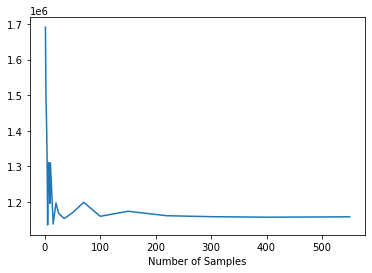

In [278]:
# converge_Series = 
pd.Series(data = test_vals*-1, index = num_sces).plot.line(
#         title = , 
    )

In [277]:
converge_Series.T.to_excel('converge_test_500samples.xlsx')

In [271]:
converge_Series.index.names = ['Number of Samples']

In [276]:
plot_labels = {
        'x': 'Number of Samples', 
        'y': 'Objective Value [Euro]'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
fig = px.line(converge_Series, 
          x=converge_Series.index, 
          y=converge_Series, 
          title='Convergence of SAA',
          labels = plot_labels

     )

fig.show()

In [53]:
# Save solutions of all subscenario models to excel sheet. This can be very slow
csap_ef.write_tree_solution('efsol.xlsx')

ERROR: evaluating object as numeric value: '2'.calA[137,peak]
        (object: <class 'pyomo.core.base.param._ParamData'>)
ERROR: evaluating object as numeric value: '2'.w_cs2poi[178,94,peak]
        (object: <class 'pyomo.core.base.expression._GeneralExpressionData'>)


KeyboardInterrupt: 

In [84]:
# MPDP.display()

In [ ]:
import mpisppy.utils.sputils as sputils

def csap_scenario_creator(
    scenario_name,    
    mpdp_frame_data: dict,
    all_sces_dict: dict,
    linearize_model: bool = True,
    model_name: str = 'EVCSAP_MPSP'
    ) -> pyo.ConcreteModel:
    if not scenario_name in all_sces_dict.keys():
        raise ValueError("Unrecognized scenario index")
    
    connect_sce = all_sces_dict[scenario_name].stack().to_dict()

    # Build Pyomo.ConcreteModel instance MPSP
    # # Multi-Period Stochastic Mixed-Interger Linear Programming (MPS-P)
    model = _build_mpsp_csap_from_mpdp_frame( 
        mpdp_frame_data = mpdp_frame_data, 
        cs_ss_connect_sce = connect_sce,
        m_name = model_name, 
        linearized = linearize_model
    )

    # Define First Stage (Determinisitic) Node ()
    sputils.attach_root_node(
        model=model,
        firstobj = model.first_stage_cost,
        varlist = [model.x, model.y, model.z, # CS/CD first stage DVs
            model.x_hat, model.chi, model.calE, # Auxiliary first stage CS/CD DVs to linearize model
            model.h # SS first stage expansion DV
        ]
    )
    model._mpisppy_probability = 1.0 / len(all_sces_dict)
    
    return model


from mpisppy.opt.ef import ExtensiveForm
options = {"solver": "cplex"}
MPSP_ef = ExtensiveForm(
            options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs = {
                "mpdp_frame_data": frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
        )
solver_results = MPSP_ef.solve_extensive_form()

objval = ef.get_objective_value()
print(f"{objval:.1f}")
solution = ef.get_root_solution()
for (var_name, var_value) in solution.items():
print(var_name, var_value)

In [ ]:
## Store results in the dict
print("Storing test results ... ")
results_prob_descrip = results['Problem'][0]
results_solver_info = results['Solver'][0]
current_obj_val = results['Solution'][0]['Objective']['__default_objective__']['Value']

if SP == True:
    csap_subsces = csap_ef.scenarios()
    subsce_name, subscemodel = next(csap_subsce)
    SP_one_subscemodel_data = SupSP._get_data_from_frame_model(frame_model = subscemodel)
else:
    model_data = SupSP._get_data_from_frame_model(frame_model = model)
## Store CSAP decisions

test_result_dict[test_id] = {
    'num_scenarios': num_sces,
    'ids_scenarios': selected_sces_names,
    'objective_value' : current_obj_val,
    'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
    'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
    'gap' : results['Solution'][0]['Gap'], 
    'one_subsceModel_data' : SP_one_subscemodel_data
    # 'mpsp_csap_decisions': mpsp_decisions 
}
print('Done\n---------------------------------------\n')